In [ ]:
!git clone https://github.com/AndreyK2001/BERT-Classification

Cloning into 'BERT-Classification'...
remote: Enumerating objects: 76, done.
remote: Counting objects: 100% (76/76), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 76 (delta 26), reused 61 (delta 16), pack-reused 0
Receiving objects: 100% (76/76), 35.43 MiB | 20.98 MiB/s, done.
Resolving deltas: 100% (26/26), done.


In [ ]:
import torch
from tqdm.notebook import tqdm

from transformers import BertTokenizer
from torch.utils.data import TensorDataset

from transformers import BertForSequenceClassification
import pandas as pd
import numpy as np

df = pd.read_csv('/content/BERT-Classification/wikidatasests/data_en.csv')
df.head()

,text,class
0,Jessica Biel is an actress. She was on the TV ...,Easy
1,Honda is a car company. The civic is a kind of...,Easy
2,A minigame is a game that is part of another g...,Easy
3,Puppis is a constellation that can be seen in ...,Easy
4,"Orkney, also known as the Orkney Islands, are ...",Easy


In [ ]:
df['class'].value_counts()

Easy      1000
Normal    1000
Name: class, dtype: int64

In [ ]:
#possible_labels = df['class'].unique()

#label_dict = {}
#for index, possible_label in enumerate(possible_labels):
#    label_dict[possible_label] = index
#label_dict

#label_dict = {'Very Easy': 0, 'Easy': 1, 'Normal': 2,'Hard': 3, 'Very Hard': 4}
label_dict = {'Easy': 0, 'Normal': 1}

In [ ]:
df['label'] = df['class'].replace(label_dict)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(df.index.values,
                                                  df.label.values,
                                                  test_size=0.15,
                                                  stratify=df.label.values)

df['data_type'] = ['not_set']*df.shape[0]

df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'

df.groupby(['class', 'label', 'data_type']).count().sort_values(['label'])

text
class  label data_type      
Easy   0     train       850
             val         150
Normal 1     train       850
             val         150

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased',
                                          do_lower_case=True)

encoded_data_train = tokenizer.batch_encode_plus(
    df[df.data_type=='train'].text.values,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=256,
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    df[df.data_type=='val'].text.values,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=256,
    return_tensors='pt'
)


input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df[df.data_type=='train'].label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(df[df.data_type=='val'].label.values)

dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pa

In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 3

dataloader_train = DataLoader(dataset_train,
                              sampler=RandomSampler(dataset_train),
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val,
                                   sampler=SequentialSampler(dataset_val),
                                   batch_size=batch_size)

In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(),
                  lr=1e-5,
                  eps=1e-8)

epochs = 3

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
from sklearn.metrics import f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}

    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        tqdm.write(f'Class: {label_dict_inverse[label]}')
        tqdm.write(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

def plot_confusion_matrix(preds, labels, label_dict):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    label_to_name = {value: key for key, value in label_dict.items()}

    # Вычисляем confusion matrix
    cm = confusion_matrix(labels_flat, preds_flat)
    label_names = list(label_dict.keys()) #['Easy', 'Normal']
    #label_names = ['Very Easy', 'Easy', 'Normal', 'Hard', 'Very Hard']#[label_to_name.get(label, "Unknown") for label in np.unique(labels_flat)]

    # Визуализация confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm[::-1], annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names[::-1])
    plt.title('Confusion Matrix')
    plt.ylabel('Истинные классы')
    plt.xlabel('Предсказанные классы')
    plt.show()


def metrics_per_class(preds, labels, label_dict):
    label_dict_inverse = {v: k for k, v in label_dict.items()}

    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    # Calculate confusion matrix
    cm = confusion_matrix(labels_flat, preds_flat)

    for label in np.unique(labels_flat):
        # True Positives
        TP = cm[label, label]
        # False Positives: sum of the corresponding column minus TP
        FP = np.sum(cm[:, label]) - TP
        # False Negatives: sum of the corresponding row minus TP
        FN = np.sum(cm[label, :]) - TP

        precision = TP / (TP + FP) if (TP + FP) != 0 else 0
        recall = TP / (TP + FN) if (TP + FN) != 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

        tqdm.write(f'Class: {label_dict_inverse[label]}')
        tqdm.write(f'Accuracy: {TP}/{TP+FN} (True Positives / Total Actual Positives)')
        tqdm.write(f'Precision: {precision:.2f}')
        tqdm.write(f'Recall: {recall:.2f}')
        tqdm.write(f'F1 Score: {f1:.2f}\n')

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/567 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.41151285978613955
Validation loss: 0.26545426457654686
F1 Score (Weighted): 0.9298245614035087


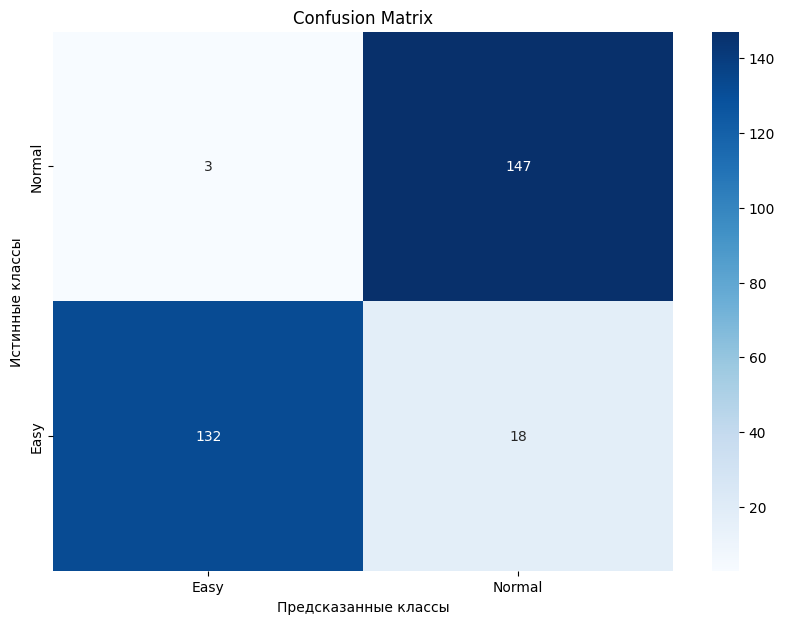

Class: Easy
Accuracy: 132/150 (True Positives / Total Actual Positives)
Precision: 0.98
Recall: 0.88
F1 Score: 0.93

Class: Normal
Accuracy: 147/150 (True Positives / Total Actual Positives)
Precision: 0.89
Recall: 0.98
F1 Score: 0.93



Epoch 2:   0%|          | 0/567 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.16720819080046648
Validation loss: 0.22657299497252098
F1 Score (Weighted): 0.96


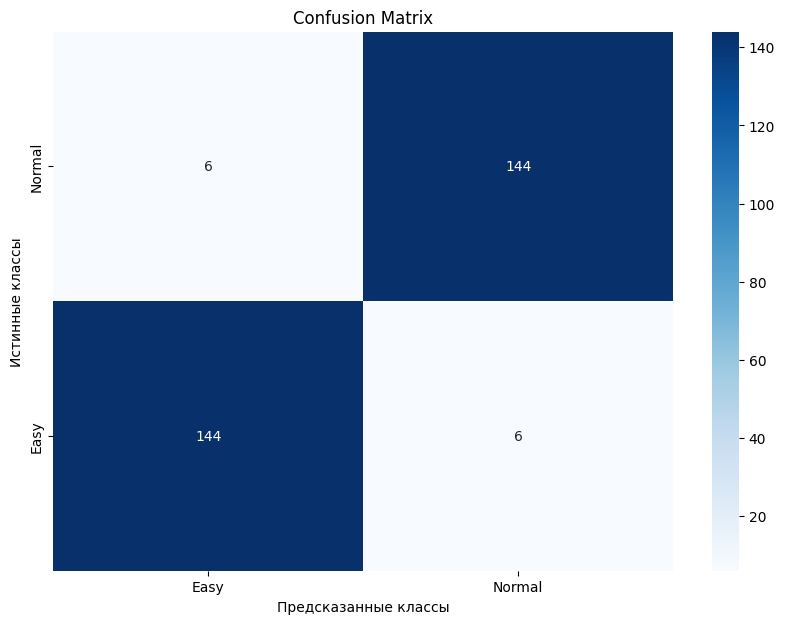

Class: Easy
Accuracy: 144/150 (True Positives / Total Actual Positives)
Precision: 0.96
Recall: 0.96
F1 Score: 0.96

Class: Normal
Accuracy: 144/150 (True Positives / Total Actual Positives)
Precision: 0.96
Recall: 0.96
F1 Score: 0.96



Epoch 3:   0%|          | 0/567 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.09060555632512896
Validation loss: 0.29337768484590926
F1 Score (Weighted): 0.9566276315350483


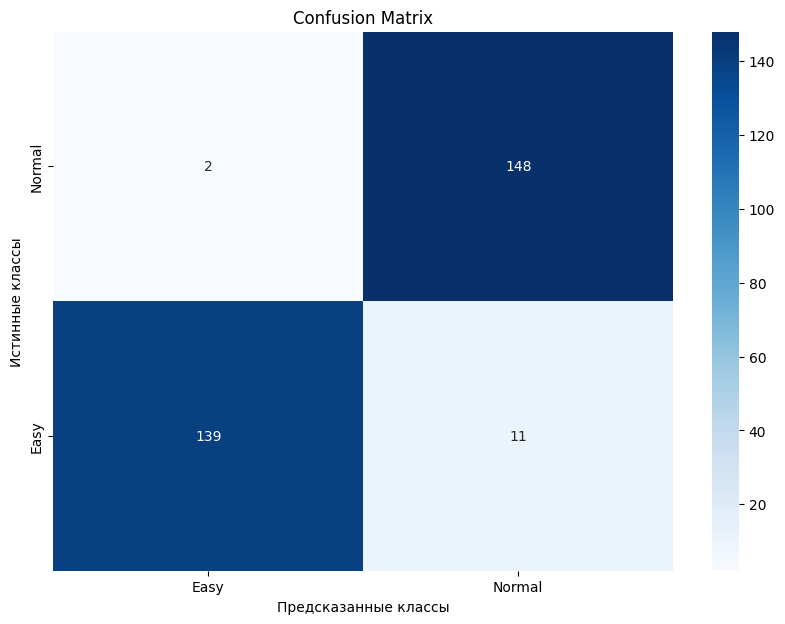

Class: Easy
Accuracy: 139/150 (True Positives / Total Actual Positives)
Precision: 0.99
Recall: 0.93
F1 Score: 0.96

Class: Normal
Accuracy: 148/150 (True Positives / Total Actual Positives)
Precision: 0.93
Recall: 0.99
F1 Score: 0.96



In [ ]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

device = 'cuda'

model = model.to(device)

def evaluate(dataloader_val):

    model.eval()

    loss_val_total = 0
    predictions, true_vals = [], []

    for batch in dataloader_val:

        batch = tuple(b.to(device) for b in batch)

        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():
            outputs = model(**inputs)

        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)

    loss_val_avg = loss_val_total/len(dataloader_val)

    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)

    return loss_val_avg, predictions, true_vals

for epoch in tqdm(range(1, epochs+1)):

    model.train()

    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()

        batch = tuple(b.to(device) for b in batch)

        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        outputs = model(**inputs)

        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})



    tqdm.write(f'\nEpoch {epoch}')

    loss_train_avg = loss_train_total/len(dataloader_train)
    tqdm.write(f'Training loss: {loss_train_avg}')

    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')
    #accuracy_per_class(predictions, true_vals)
    plot_confusion_matrix(predictions, true_vals, label_dict)
    metrics_per_class(predictions, true_vals, label_dict)

Languages:   0%|          | 0/9 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pa

ru
Predictions loss: 0.4749459964868116
F1 Score (Weighted): 0.901584193216339


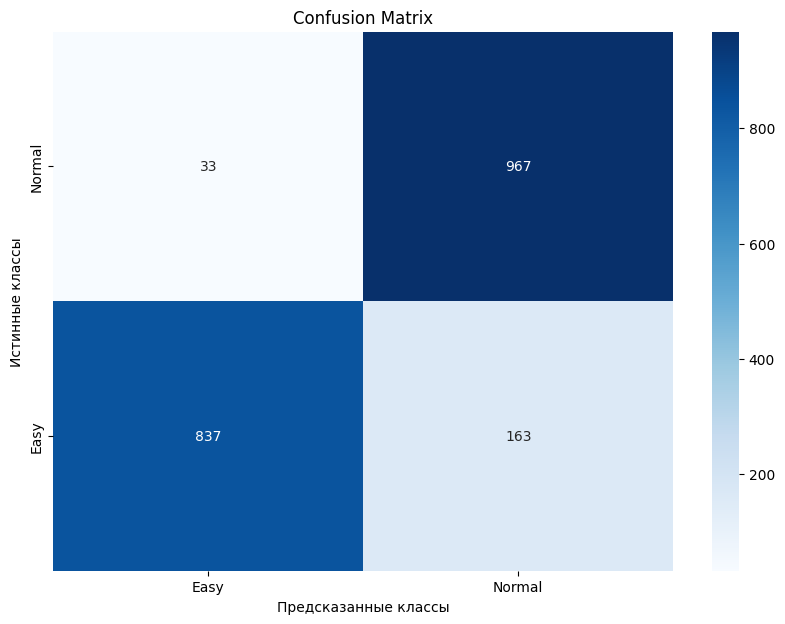

Class: Easy
Accuracy: 837/1000 (True Positives / Total Actual Positives)
Precision: 0.96
Recall: 0.84
F1 Score: 0.90

Class: Normal
Accuracy: 967/1000 (True Positives / Total Actual Positives)
Precision: 0.86
Recall: 0.97
F1 Score: 0.91



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pa

ca
Predictions loss: 0.5962405617072996
F1 Score (Weighted): 0.879


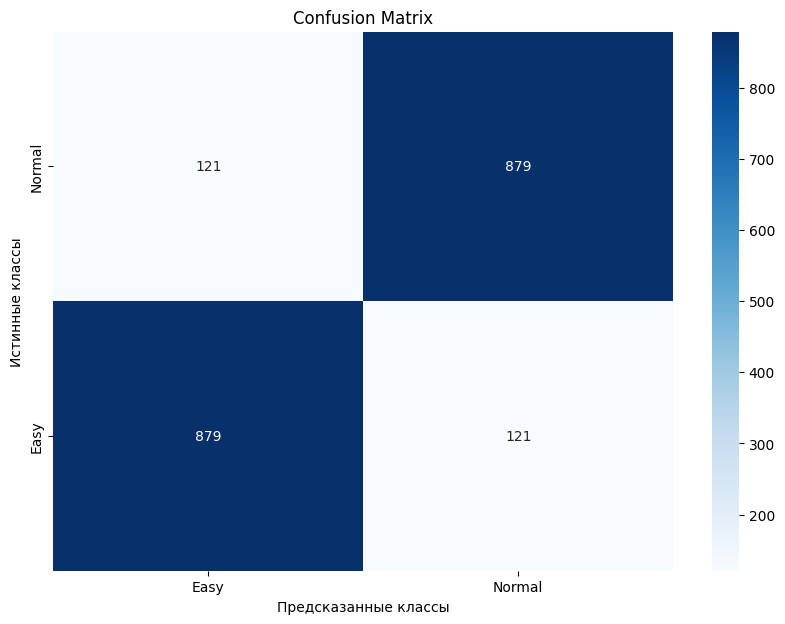

Class: Easy
Accuracy: 879/1000 (True Positives / Total Actual Positives)
Precision: 0.88
Recall: 0.88
F1 Score: 0.88

Class: Normal
Accuracy: 879/1000 (True Positives / Total Actual Positives)
Precision: 0.88
Recall: 0.88
F1 Score: 0.88



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pa

el
Predictions loss: 1.0496677460238468
F1 Score (Weighted): 0.7579858946873337


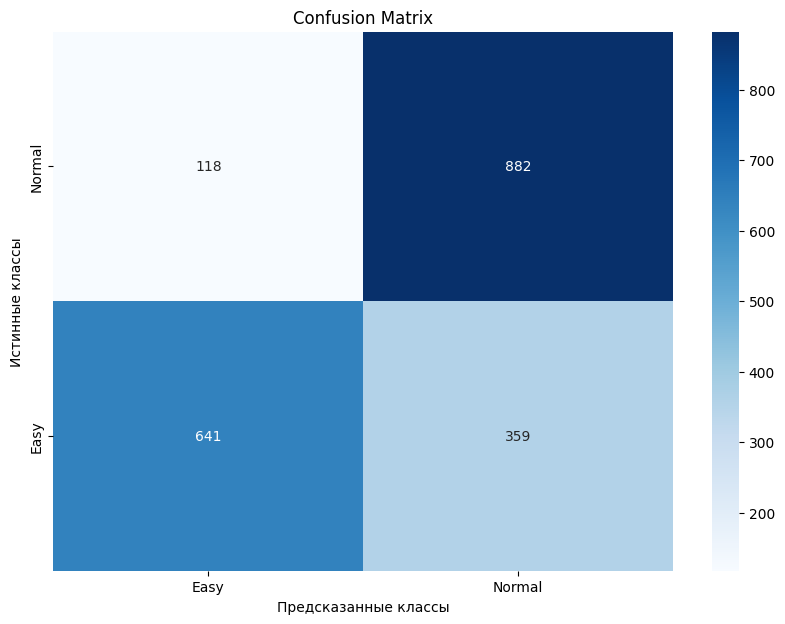

Class: Easy
Accuracy: 641/1000 (True Positives / Total Actual Positives)
Precision: 0.84
Recall: 0.64
F1 Score: 0.73

Class: Normal
Accuracy: 882/1000 (True Positives / Total Actual Positives)
Precision: 0.71
Recall: 0.88
F1 Score: 0.79



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pa

es
Predictions loss: 0.854263360291385
F1 Score (Weighted): 0.8262273451478531


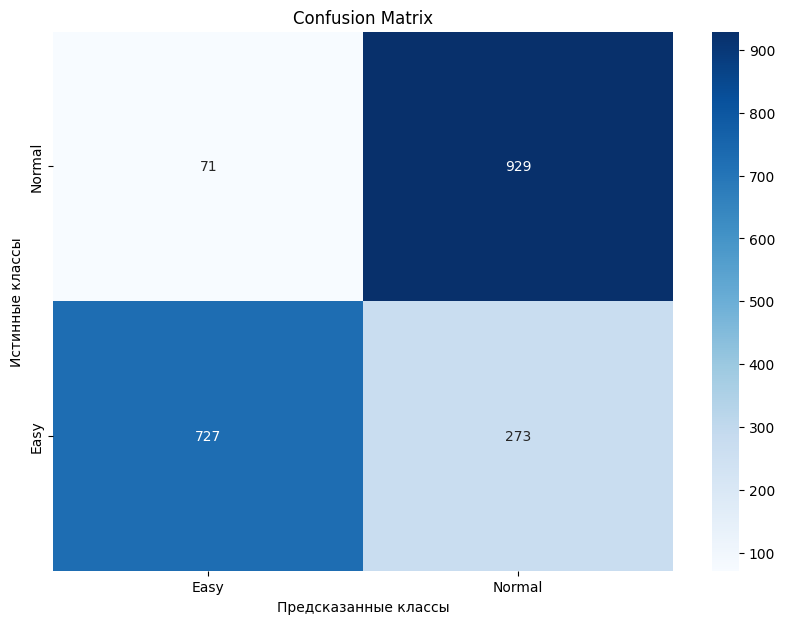

Class: Easy
Accuracy: 727/1000 (True Positives / Total Actual Positives)
Precision: 0.91
Recall: 0.73
F1 Score: 0.81

Class: Normal
Accuracy: 929/1000 (True Positives / Total Actual Positives)
Precision: 0.77
Recall: 0.93
F1 Score: 0.84



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pa

eu
Predictions loss: 1.3017324512665414
F1 Score (Weighted): 0.7013501271559266


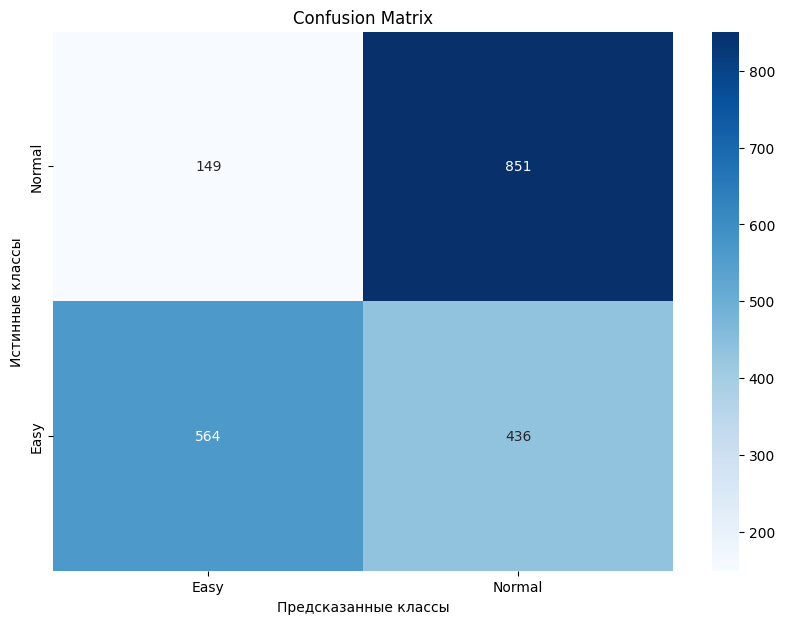

Class: Easy
Accuracy: 564/1000 (True Positives / Total Actual Positives)
Precision: 0.79
Recall: 0.56
F1 Score: 0.66

Class: Normal
Accuracy: 851/1000 (True Positives / Total Actual Positives)
Precision: 0.66
Recall: 0.85
F1 Score: 0.74



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pa

fr
Predictions loss: 1.153790546395225
F1 Score (Weighted): 0.7708467569584884


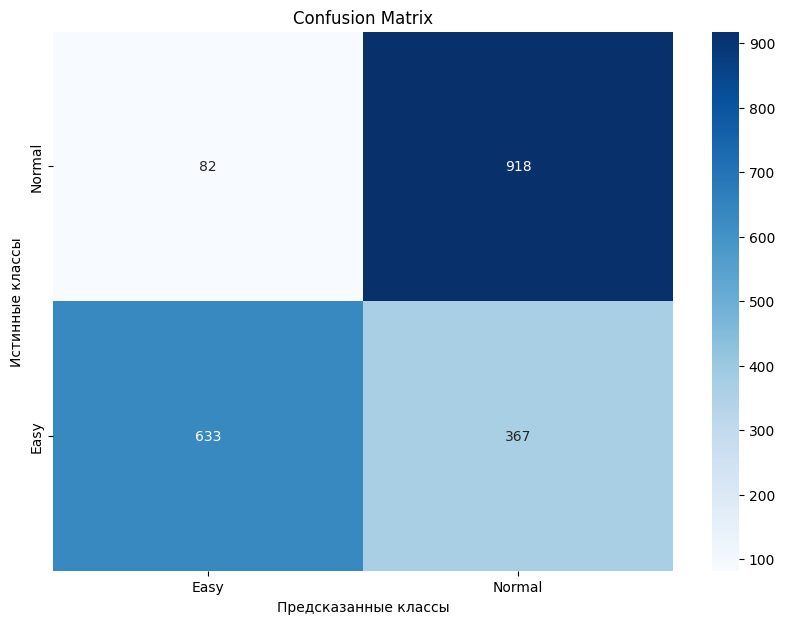

Class: Easy
Accuracy: 633/1000 (True Positives / Total Actual Positives)
Precision: 0.89
Recall: 0.63
F1 Score: 0.74

Class: Normal
Accuracy: 918/1000 (True Positives / Total Actual Positives)
Precision: 0.71
Recall: 0.92
F1 Score: 0.80



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pa

it
Predictions loss: 1.0691911712729734
F1 Score (Weighted): 0.7549524749671057


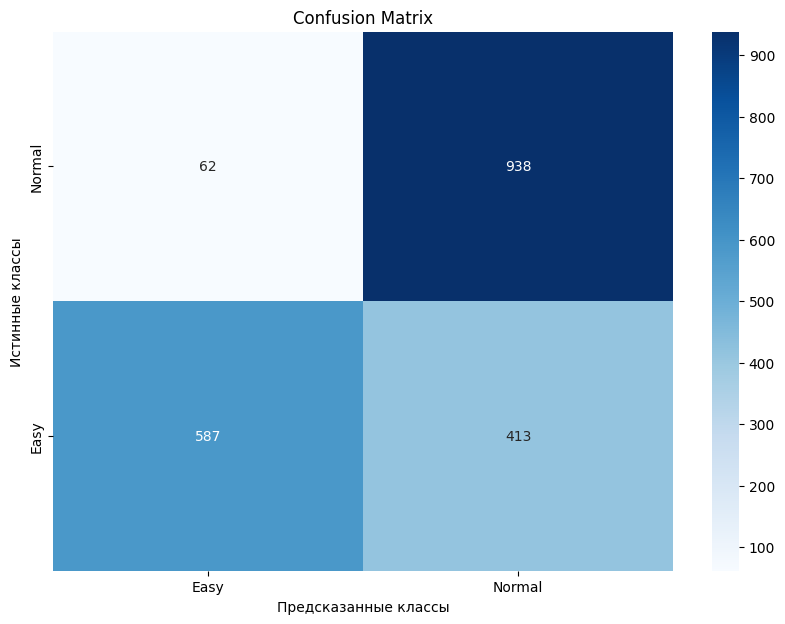

Class: Easy
Accuracy: 587/1000 (True Positives / Total Actual Positives)
Precision: 0.90
Recall: 0.59
F1 Score: 0.71

Class: Normal
Accuracy: 938/1000 (True Positives / Total Actual Positives)
Precision: 0.69
Recall: 0.94
F1 Score: 0.80



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pa

oc
Predictions loss: 2.3056508239065097
F1 Score (Weighted): 0.4999994669503912


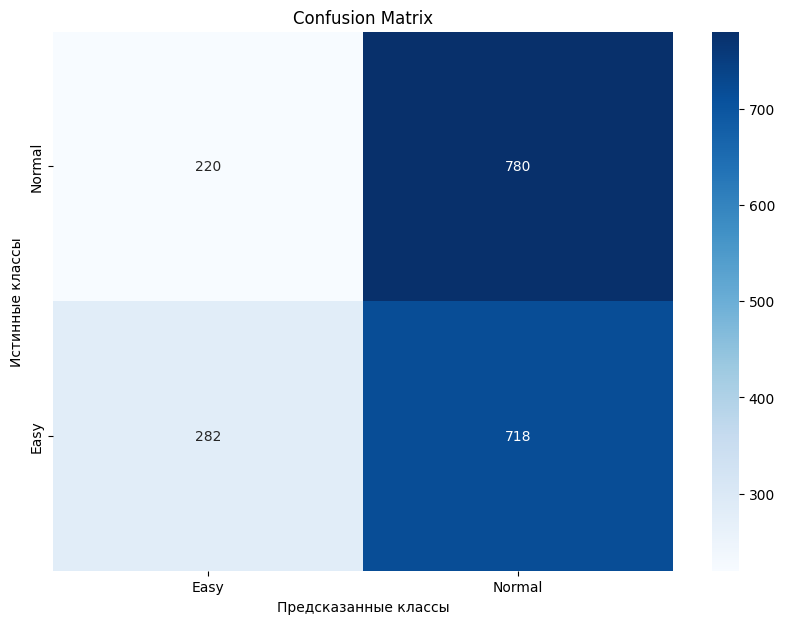

Class: Easy
Accuracy: 282/1000 (True Positives / Total Actual Positives)
Precision: 0.56
Recall: 0.28
F1 Score: 0.38

Class: Normal
Accuracy: 780/1000 (True Positives / Total Actual Positives)
Precision: 0.52
Recall: 0.78
F1 Score: 0.62



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pa

pt
Predictions loss: 0.6400903177792238
F1 Score (Weighted): 0.8593514399584562


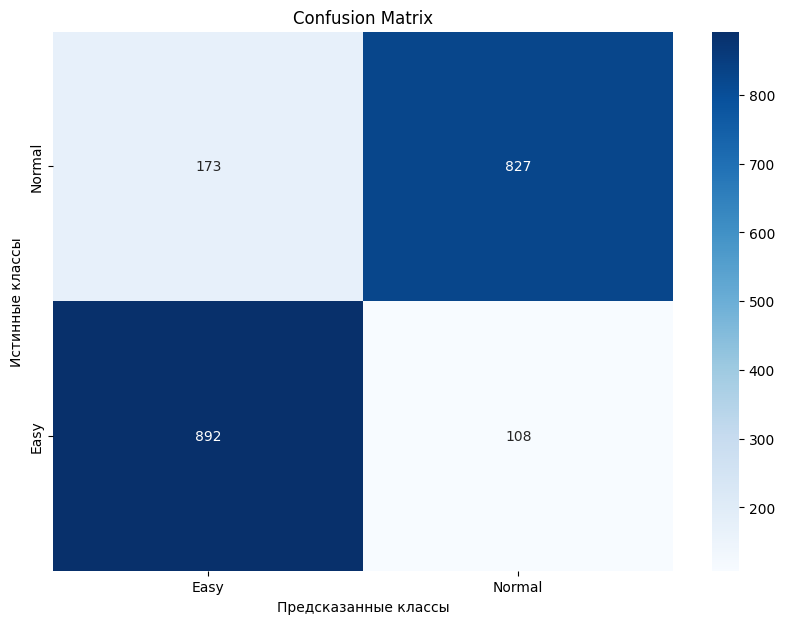

Class: Easy
Accuracy: 892/1000 (True Positives / Total Actual Positives)
Precision: 0.84
Recall: 0.89
F1 Score: 0.86

Class: Normal
Accuracy: 827/1000 (True Positives / Total Actual Positives)
Precision: 0.88
Recall: 0.83
F1 Score: 0.85



In [ ]:
for language in tqdm(['ru', 'ca', 'el', 'es', 'eu', 'fr', 'it', 'oc', 'pt'], desc="Languages"): #tqdm(['en', 'ru', 'ar', 'ca', 'de', 'el', 'es', 'eu', 'fr', 'hy', 'it', 'oc', 'pt'], desc="Languages"):

    df = pd.read_csv(f'/content/BERT-Classification/wikidatasests/data_{language}.csv')
    df.columns = ['text', 'class']
    df['label'] = df['class'].replace(label_dict)

    tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased',
                                          do_lower_case=True)

    encoded_data_predict = tokenizer.batch_encode_plus(
        df.text.values,
        add_special_tokens=True,
        return_attention_mask=True,
        pad_to_max_length=True,
        max_length=256,
        return_tensors='pt'
    )

    input_ids_predict = encoded_data_predict['input_ids']
    attention_masks_predict = encoded_data_predict['attention_mask']
    labels_predict = torch.tensor(df.label.values)

    dataset_predict = TensorDataset(input_ids_predict, attention_masks_predict, labels_predict)


    batch_size = 3

    dataloader_predict = DataLoader(dataset_predict,
                                  sampler=RandomSampler(dataset_predict),
                                  batch_size=batch_size)

    predict_loss, predictions, true_predict = evaluate(dataloader_predict)
    predict_f1 = f1_score_func(predictions, true_predict)

    print(language)
    print(f'Predictions loss: {predict_loss}')
    print(f'F1 Score (Weighted): {predict_f1}')
    plot_confusion_matrix(predictions, true_predict, label_dict)
    metrics_per_class(predictions, true_predict, label_dict)